# INFOMATION

### python info
 - Version : 3.6.10
 - Anaconda ver 4.8.2
 
### package info
 - tensorflow ver 2.1.0
 - numpy ver 1.19.1
 - pandas ver 1.1.1

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

import os

# data array
import pandas as pd
import numpy as np
# print 내 지수표현식 방지
np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.2f}".format(x)})

# nomalization
from sklearn.preprocessing import MinMaxScaler as scaler
from sklearn.metrics import mean_squared_error

# return variable name
from varname import nameof

# dataframe visualization
import qgrid

- matplotlib 오류 방지

In [2]:
import matplotlib
if "DISPLAY" not in os.environ:
    # remove Travis CI Error
    matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
%matplotlib inline

# SETTING
 ### function

In [3]:
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        x = time_series[i:i + seq_length,:-1]
        y = time_series[i + seq_length, [-1]]  # Next close price

        dataX.append(x)
        dataY.append(y)
        if i <=10:
            print('{}번째'.format(i))
            print(x, "->", y)
            print('='*10)
            
    return np.array(dataX), np.array(dataY)

### parameter

In [4]:
# train Parameters
seq_length = 5
data_dim = 3
output_dim = 1
learning_rate = 0.001
iterations = 1000

### Data
 - load data

In [5]:
xy = pd.read_csv('test_kk.csv')
qgrid.show_grid(xy,show_toolbar=True)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

- 시계열 컬럼 삭제 및 부동소수점으로 변환

In [6]:
del xy['date']
xy = xy.values[1:].astype(np.float)
# xy = xy[::-1]  # reverse order (chronically ordered) <- already reverse

- 데이터 시각화

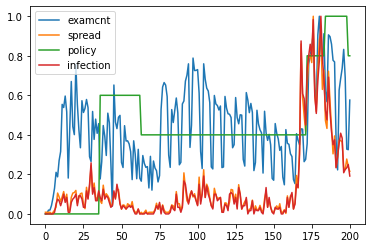

In [7]:
scal = scaler()
scal_tf = scal.fit_transform(xy)

plt.plot(scal_tf[:,[0]],label = 'examcnt')
plt.plot(scal_tf[:,[1]],label = 'spread')
plt.plot(scal_tf[:,[2]],label = 'policy')
plt.plot(scal_tf[:,[3]],label = 'infection')
plt.legend()
plt.show()

- 학습용 / 테스트용 분리

In [8]:
train_size = int(len(xy) * 0.85)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

 - 스케일링 (Min-Max Scaling)
     > 1. x, y 스케일러 인스턴스 생성
     > 2. x, y 전체 피팅 생성
     > 3. 학습용 / 테스트용 스케일링 변환
     > * 나누는 목적
     >> 나중에 inverse 할때 예상값과 같은 배열 크기여야 가능하다.

In [9]:
min_max_x = scaler()
min_max_y = scaler()

min_max_x_fit = min_max_x.fit(xy[:,:-1])
min_max_y_fit = min_max_y.fit(xy[:,[-1]])

train_set_sc_x = min_max_x.transform(train_set[:, :-1])
train_set_sc_y = min_max_y.transform(train_set[:, [-1]])
test_set_sc_x = min_max_x.transform(test_set[:, :-1])
test_set_sc_y = min_max_y.transform(test_set[:, [-1]])

print(train_set_sc_x[:10])
print('-'*10)
print(train_set[:10,:-1])
print('-'*10)
print(min_max_x.inverse_transform(train_set_sc_x)[:10])

[[0.00 0.01 0.00]
 [0.00 0.01 0.00]
 [0.02 0.01 0.00]
 [0.02 0.01 0.00]
 [0.04 0.00 0.00]
 [0.08 0.01 0.00]
 [0.13 0.02 0.00]
 [0.21 0.03 0.00]
 [0.19 0.11 0.00]
 [0.27 0.09 0.00]]
----------
[[55.00 0.04 0.00]
 [105.00 0.04 0.00]
 [498.00 0.04 0.00]
 [512.00 0.04 0.00]
 [1053.00 0.01 0.00]
 [1976.00 0.04 0.00]
 [3098.00 0.07 0.00]
 [4957.00 0.12 0.00]
 [4424.00 0.35 0.00]
 [6346.00 0.29 0.00]]
----------
[[55.00 0.04 0.00]
 [105.00 0.04 0.00]
 [498.00 0.04 0.00]
 [512.00 0.04 0.00]
 [1053.00 0.01 0.00]
 [1976.00 0.04 0.00]
 [3098.00 0.07 0.00]
 [4957.00 0.12 0.00]
 [4424.00 0.35 0.00]
 [6346.00 0.29 0.00]]


 - 원상복귀 시켜준다.

In [10]:
train_set = np.concatenate((train_set_sc_x,train_set_sc_y), axis=1)
test_set = np.concatenate((test_set_sc_x,test_set_sc_y), axis=1)
print(train_set[:3])
print('-'*10)
print(test_set[:3])

[[0.00 0.01 0.00 0.00]
 [0.00 0.01 0.00 0.00]
 [0.02 0.01 0.00 0.00]]
----------
[[0.41 0.19 0.40 0.15]
 [0.37 0.13 0.40 0.13]
 [0.35 0.33 0.40 0.30]]


 - 학습 / 테스트 데이터 구분

In [11]:
print('Data Name is {}'.format(nameof(train_set)))
trainX, trainY = build_dataset(train_set, seq_length)

print('\n\n')

print('Data Name is {}'.format(nameof(test_set)))
testX, testY = build_dataset(test_set, seq_length)

print(trainX.shape,testX.shape)

Data Name is train_set
0번째
[[0.00 0.01 0.00]
 [0.00 0.01 0.00]
 [0.02 0.01 0.00]
 [0.02 0.01 0.00]
 [0.04 0.00 0.00]] -> [0.00]
1번째
[[0.00 0.01 0.00]
 [0.02 0.01 0.00]
 [0.02 0.01 0.00]
 [0.04 0.00 0.00]
 [0.08 0.01 0.00]] -> [0.01]
2번째
[[0.02 0.01 0.00]
 [0.02 0.01 0.00]
 [0.04 0.00 0.00]
 [0.08 0.01 0.00]
 [0.13 0.02 0.00]] -> [0.05]
3번째
[[0.02 0.01 0.00]
 [0.04 0.00 0.00]
 [0.08 0.01 0.00]
 [0.13 0.02 0.00]
 [0.21 0.03 0.00]] -> [0.07]
4번째
[[0.04 0.00 0.00]
 [0.08 0.01 0.00]
 [0.13 0.02 0.00]
 [0.21 0.03 0.00]
 [0.19 0.11 0.00]] -> [0.07]
5번째
[[0.08 0.01 0.00]
 [0.13 0.02 0.00]
 [0.21 0.03 0.00]
 [0.19 0.11 0.00]
 [0.27 0.09 0.00]] -> [0.04]
6번째
[[0.13 0.02 0.00]
 [0.21 0.03 0.00]
 [0.19 0.11 0.00]
 [0.27 0.09 0.00]
 [0.32 0.06 0.00]] -> [0.07]
7번째
[[0.21 0.03 0.00]
 [0.19 0.11 0.00]
 [0.27 0.09 0.00]
 [0.32 0.06 0.00]
 [0.55 0.09 0.00]] -> [0.10]
8번째
[[0.19 0.11 0.00]
 [0.27 0.09 0.00]
 [0.32 0.06 0.00]
 [0.55 0.09 0.00]
 [0.54 0.11 0.00]] -> [0.06]
9번째
[[0.27 0.09 0.00]
 [0.32 0.0

 ### LSTM Modeling
  - 셀 지정

In [12]:
# tf.random.set_seed(777)
tf.model = tf.keras.Sequential()
tf.model.add(tf.keras.layers.LSTM(units=4,input_shape=(seq_length, data_dim), return_sequences=True))
tf.model.add(tf.keras.layers.LSTM(units=4, return_sequences=False))
tf.model.add(tf.keras.layers.Dense(units=output_dim, activation='linear'))
tf.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 4)              128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 144       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 277
Trainable params: 277
Non-trainable params: 0
_________________________________________________________________


 - Compile 지정

In [13]:
tf.model.compile(loss='mse',
                 # optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                 optimizer='adam',
                 metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min',patience = 20)

h = tf.model.fit(trainX, trainY,
                 epochs=iterations,
                 batch_size=4,
                 validation_data=[testX,testY],
                 verbose=2,
                 callbacks = [es]
                )

Train on 165 samples, validate on 31 samples
Epoch 1/1000
165/165 - 4s - loss: 0.0116 - accuracy: 0.1333 - val_loss: 0.2755 - val_accuracy: 0.0000e+00
Epoch 2/1000
165/165 - 0s - loss: 0.0083 - accuracy: 0.1333 - val_loss: 0.2499 - val_accuracy: 0.0000e+00
Epoch 3/1000
165/165 - 0s - loss: 0.0083 - accuracy: 0.1333 - val_loss: 0.2450 - val_accuracy: 0.0000e+00
Epoch 4/1000
165/165 - 0s - loss: 0.0082 - accuracy: 0.1333 - val_loss: 0.2453 - val_accuracy: 0.0000e+00
Epoch 5/1000
165/165 - 0s - loss: 0.0081 - accuracy: 0.1333 - val_loss: 0.2421 - val_accuracy: 0.0000e+00
Epoch 6/1000
165/165 - 0s - loss: 0.0081 - accuracy: 0.1333 - val_loss: 0.2384 - val_accuracy: 0.0000e+00
Epoch 7/1000
165/165 - 0s - loss: 0.0081 - accuracy: 0.1333 - val_loss: 0.2321 - val_accuracy: 0.0000e+00
Epoch 8/1000
165/165 - 0s - loss: 0.0081 - accuracy: 0.1333 - val_loss: 0.2339 - val_accuracy: 0.0000e+00
Epoch 9/1000
165/165 - 0s - loss: 0.0081 - accuracy: 0.1333 - val_loss: 0.2324 - val_accuracy: 0.0000e+00
E

Epoch 79/1000
165/165 - 0s - loss: 0.0043 - accuracy: 0.1333 - val_loss: 0.0266 - val_accuracy: 0.0323
Epoch 80/1000
165/165 - 0s - loss: 0.0043 - accuracy: 0.1333 - val_loss: 0.0282 - val_accuracy: 0.0323
Epoch 81/1000
165/165 - 0s - loss: 0.0043 - accuracy: 0.1333 - val_loss: 0.0266 - val_accuracy: 0.0323
Epoch 82/1000
165/165 - 0s - loss: 0.0043 - accuracy: 0.1333 - val_loss: 0.0260 - val_accuracy: 0.0323
Epoch 83/1000
165/165 - 0s - loss: 0.0044 - accuracy: 0.1333 - val_loss: 0.0265 - val_accuracy: 0.0323
Epoch 84/1000
165/165 - 0s - loss: 0.0042 - accuracy: 0.1333 - val_loss: 0.0265 - val_accuracy: 0.0323
Epoch 85/1000
165/165 - 0s - loss: 0.0042 - accuracy: 0.1333 - val_loss: 0.0271 - val_accuracy: 0.0323
Epoch 86/1000
165/165 - 0s - loss: 0.0042 - accuracy: 0.1333 - val_loss: 0.0265 - val_accuracy: 0.0323
Epoch 87/1000
165/165 - 0s - loss: 0.0043 - accuracy: 0.1333 - val_loss: 0.0262 - val_accuracy: 0.0323
Epoch 88/1000
165/165 - 0s - loss: 0.0042 - accuracy: 0.1333 - val_loss: 

 -  Modeling 예측

In [14]:
test_predict = tf.model.predict(testX)

MSE = mean_squared_error(testY,test_predict)
RMSE = np.sqrt(MSE)

pred_score = 100 * ( 1 - (((test_predict - testY)**2).sum())/((testY**2).sum()))

print('MSE : {} , RMSE : {} , score : {}'.format(MSE,RMSE,pred_score))
np.array(min_max_y.inverse_transform(test_predict), dtype=np.int)[:10]

MSE : 0.030079805866204005 , RMSE : 0.1734353074382607 , score : 90.98641659203908


array([[71],
       [63],
       [52],
       [58],
       [67],
       [75],
       [76],
       [79],
       [70],
       [63]])

 - 에러율 검출 시각화 

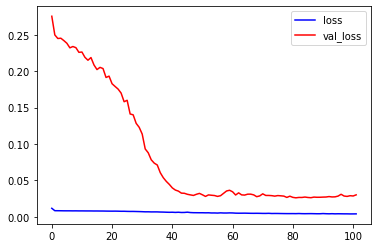

In [15]:
plt.plot(h.history['loss'], label = 'loss', color = 'b')
plt.plot(h.history['val_loss'], label = 'val_loss', color = 'r')
plt.legend()
plt.show()

 - 실제값 vs 예측값 시각화

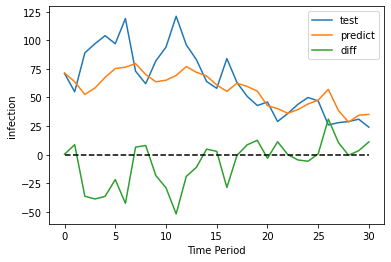

In [16]:
Ty = min_max_y.inverse_transform(testY)
Tp = min_max_y.inverse_transform(test_predict)
Td = Tp - Ty

plt.plot(Ty,label = 'test')
plt.plot(Tp,label = 'predict')
plt.plot(Td,label = 'diff')
plt.plot(np.zeros(len(Td)),'--', color = 'black')
plt.xlabel("Time Period")
plt.ylabel("infection")
plt.legend()
plt.show()

 - 학습 구간 - 예측구간 전체 시각화

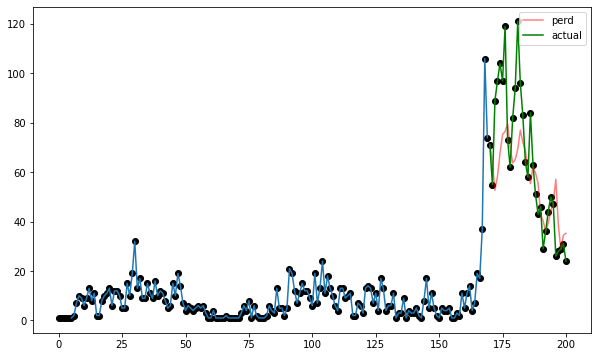

In [17]:
t_axis = np.arange(0,len(xy))
s_axis = np.arange(0,seq_length)
a_axis = np.arange(len(s_axis),len(s_axis) + len(trainY))
b_axis = np.arange(len(s_axis) + len(a_axis),len(s_axis) + len(a_axis) + len(test_predict))

plt.figure(figsize=(10,6))
plt.plot(t_axis,xy[:,-1],'o',color = 'black')
plt.plot(a_axis, min_max_y_fit.inverse_transform(trainY))
plt.plot(b_axis,min_max_y_fit.inverse_transform(test_predict), color='r', alpha=0.5, label='perd')
plt.plot(b_axis,min_max_y_fit.inverse_transform(testY), color='green', label='actual')
plt.legend()
plt.show()


 - Modeling Save Point

In [18]:
from datetime import datetime

if pred_score >=90 :
    # Save model
    model_json = tf.model.to_json()
    with open("./model_json/model_{}.json".format(datetime.now().strftime('%Y_%m_%d')), "w") as json_file : 
        json_file.write(model_json)

    # Save model weights
    tf.model.save_weights("./weight_h5/model_weight_{}_score_{}.h5".format(datetime.now().strftime('%Y_%m_%d'),int(pred_score*100)))
    print("Saved model to disk")
    
else:
    print('모델 점수가 90점 미만입니다.')

Saved model to disk


### 5일치 데이터 예측하기
 1. test_set_sc_x 값을 가져온다.

In [19]:
inv_sq_testX = min_max_x.inverse_transform(test_set_sc_x[-seq_length:])

inv_sq_testX

array([[19444.00, 0.77, 2.50],
       [16110.00, 0.74, 2.50],
       [7692.00, 0.91, 2.50],
       [7623.00, 0.78, 2.00],
       [13470.00, 0.70, 2.00]])

2. 5일치 X 예측값을 직접 작성한다.

In [20]:
predX =[[9000, 0.77, 2.0],
       [5000, 0.94, 2.0],
       [15000, 1.22, 2.0],
       [16000, 1.21, 2.0],
       [17000, 1.19, 2.0]]

predX_10 = np.concatenate((inv_sq_testX,predX),axis = 0).astype(np.float)
predX_10
predX_10_sc = min_max_x.transform(predX_10)
predX_10_dim = []

for i in range(0, len(predX_10_sc) - seq_length):
        x = predX_10_sc[i:i + seq_length,:]
        predX_10_dim.append(x)
        
predX_10_dim = np.array(predX_10_dim)
min_max_x.inverse_transform(predX_10_dim.reshape(-1,3))

array([[19444.00, 0.77, 2.50],
       [16110.00, 0.74, 2.50],
       [7692.00, 0.91, 2.50],
       [7623.00, 0.78, 2.00],
       [13470.00, 0.70, 2.00],
       [16110.00, 0.74, 2.50],
       [7692.00, 0.91, 2.50],
       [7623.00, 0.78, 2.00],
       [13470.00, 0.70, 2.00],
       [9000.00, 0.77, 2.00],
       [7692.00, 0.91, 2.50],
       [7623.00, 0.78, 2.00],
       [13470.00, 0.70, 2.00],
       [9000.00, 0.77, 2.00],
       [5000.00, 0.94, 2.00],
       [7623.00, 0.78, 2.00],
       [13470.00, 0.70, 2.00],
       [9000.00, 0.77, 2.00],
       [5000.00, 0.94, 2.00],
       [15000.00, 1.22, 2.00],
       [13470.00, 0.70, 2.00],
       [9000.00, 0.77, 2.00],
       [5000.00, 0.94, 2.00],
       [15000.00, 1.22, 2.00],
       [16000.00, 1.21, 2.00]])

3. 모델 예측 결과

In [21]:
test_predict_final_Y = tf.model.predict(predX_10_dim)
final_Y = min_max_y.inverse_transform(test_predict_final_Y)
final_Y.astype(np.int)

array([[34],
       [37],
       [45],
       [49],
       [50]])

4. 모델 예측 시각화

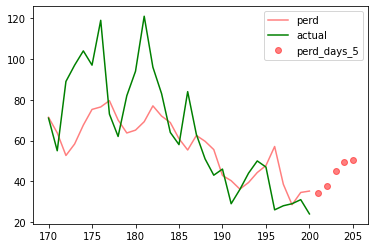

In [22]:
c_axis = np.arange(len(s_axis) + len(a_axis) + len(b_axis) ,
                   len(s_axis) + len(a_axis) + len(b_axis)+len(final_Y))

plt.plot(b_axis,min_max_y_fit.inverse_transform(test_predict), color='r', alpha=0.5, label='perd')
plt.plot(b_axis,min_max_y_fit.inverse_transform(testY), color='green', label='actual')
plt.plot(c_axis,final_Y, 'o', color = 'r', alpha=0.5, label='perd_days_5')

plt.legend()
plt.show()